# Postprocessing Transforms with spleen segmentation task

MONAI provides post-processing transforms for handling the model outputs. Currently, the transforms include:
* `Activations`: Adding activation layer (Sigmoid, Softmax, etc.).
* `AsDiscrete`: Converting to discrete values (Argmax, One-Hot, Threshold value, etc).
* `SplitChannel`: Splitting multi-channel data into multiple single channels.
* `KeepLargestConnectedComponent`: Extracting contour of segmentation result, which can be used to map to original image and evaluate the model.
* `LabelToContour`: Removing segmentation noise based on Connected Component Analysis.

MONAI supports multiple transform chains to apply different preprocessing transforms or postprocessing transforms on the same data and concatenate the results, it provides `CopyItems` transform to make copies of specified items in the data dictionary and `ConcatItems` transform to combine specified items on the expected dimension, and also provides `DeleteItems` transform to delete unnecessary items to save memory.

A typical usage is to scale and concatenate 3 different intensity ranges of an input image:
<p>
<img src="../figures/multi_transform_chains.png" width="70%" alt='multi_transform_chains'>
</p>

This tutorial shows several of above postprocessing transforms based on the model output of spleen segmentation.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/post_transforms.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, skimage, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    KeepLargestConnectedComponent,
    LabelToContour,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

## Setup imports

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 0.8.0rc1+5.g37930a9b
Numpy version: 1.21.2
Pytorch version: 1.10.0a0+0aef44c
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: 37930a9bc433ae3faf11e762550362cb8a241c43

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.4.0
Tensorboard version: 2.6.0
gdown version: 4.2.0
TorchVision version: 0.11.0a0
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.4
einops version: 0.3.2
transformers version: 4.12.5
mlflow version: 1.21.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical/


## Download dataset

Downloads and extracts the dataset.
The dataset comes from http://medicaldecathlon.com/.

In [5]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [6]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)

## Setup transforms for training and validation

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # randomly crop out patch samples from big image
        # based on pos / neg ratio. the image centers
        # of negative samples must be in valid image area
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

## Define CacheDataset and DataLoader for training and validation

In [9]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


## Create Model, Loss, Optimizer

In [10]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=True, batch=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [ ]:
max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size},"
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    # validation progress
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(),
                           "best_metric_model_post_transforms.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

## Execute postprocessing transforms on validation dataset

Here we test `AsDiscrete`, `KeepLargestConnectedComponent` and `LabelToContour`.

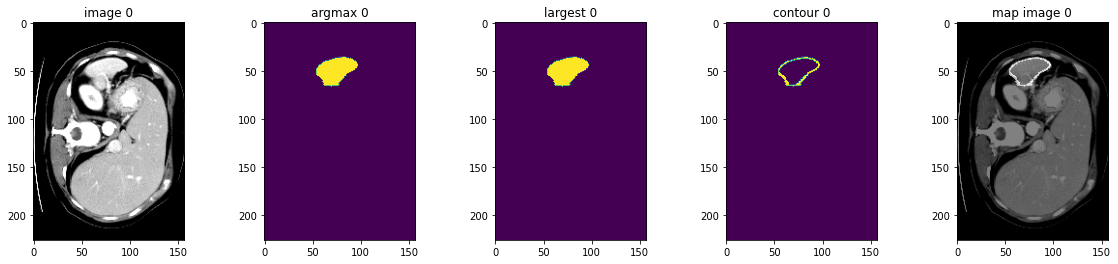

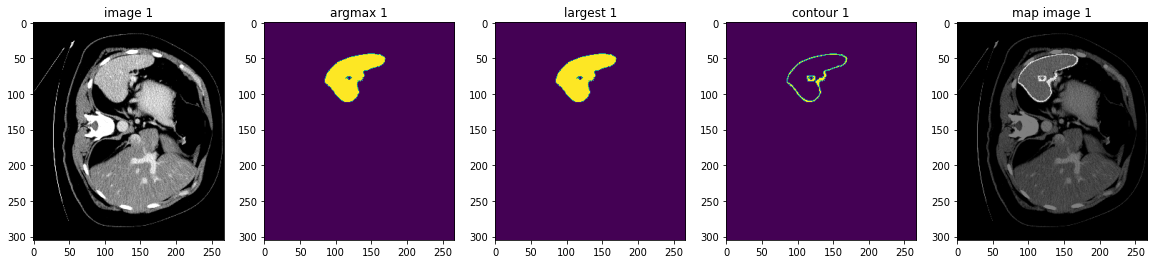

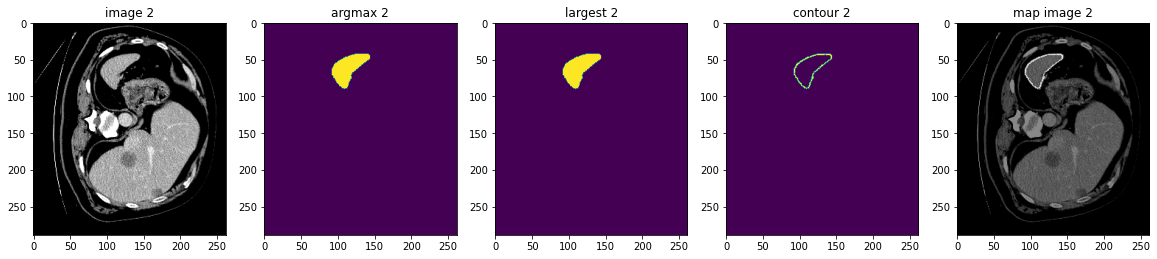

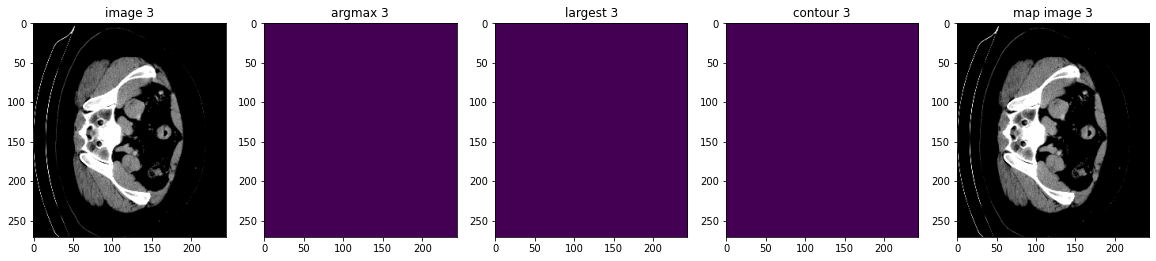

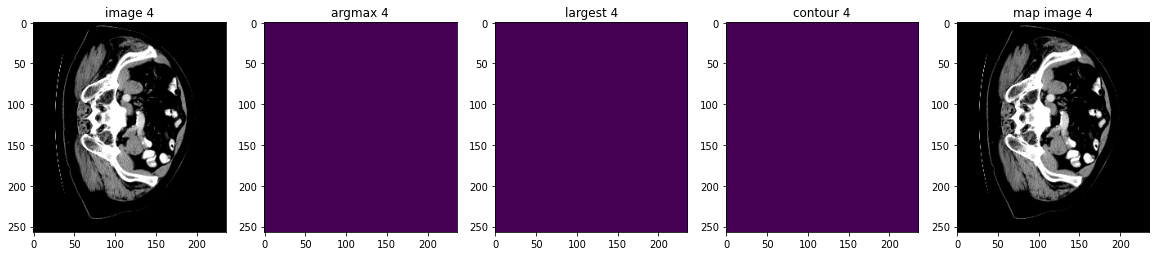

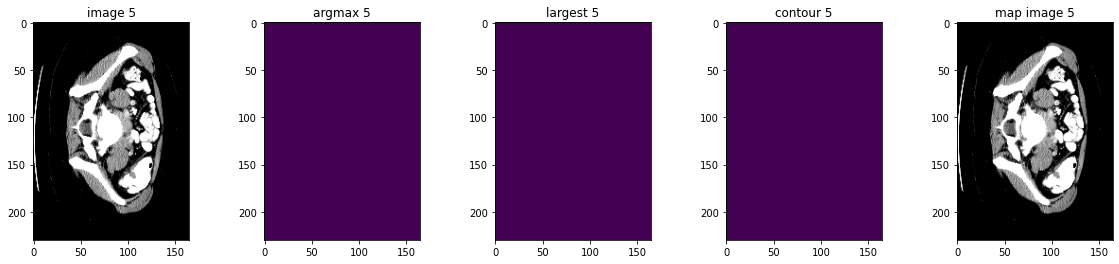

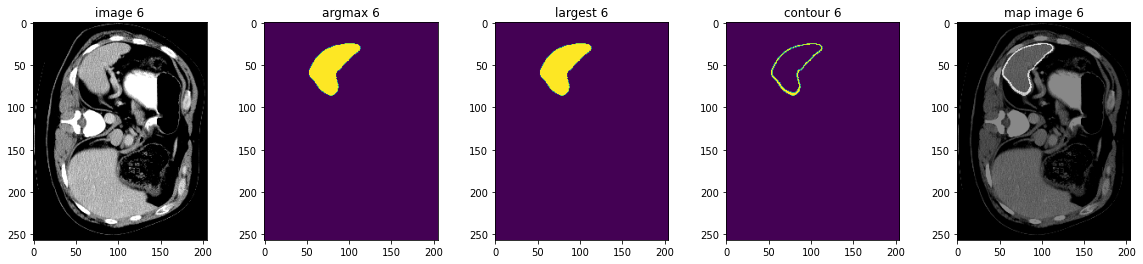

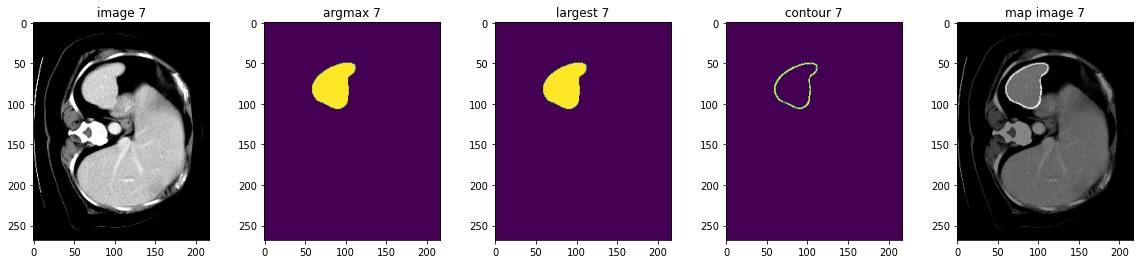

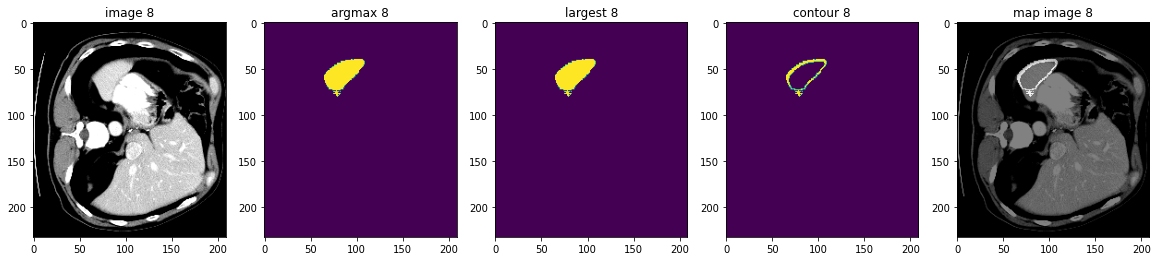

In [12]:
model.load_state_dict(torch.load("best_metric_model_post_transforms.pth"))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data = val_data["image"].to(device)
        val_output = sliding_window_inference(
            val_data, roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (20, 4))
        plt.subplot(1, 5, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 5, 2)
        plt.title(f"argmax {i}")
        argmax = [AsDiscrete(argmax=True)(i) for i in decollate_batch(val_output)]
        plt.imshow(argmax[0].detach().cpu()[0, :, :, 80])
        plt.subplot(1, 5, 3)
        plt.title(f"largest {i}")
        largest = [KeepLargestConnectedComponent(applied_labels=[1])(i) for i in argmax]
        plt.imshow(largest[0].detach().cpu()[0, :, :, 80])
        plt.subplot(1, 5, 4)
        plt.title(f"contour {i}")
        contour = [LabelToContour()(i) for i in largest]
        plt.imshow(contour[0].detach().cpu()[0, :, :, 80])
        plt.subplot(1, 5, 5)
        plt.title(f"map image {i}")
        map_image = contour[0] + val_data[0]
        plt.imshow(map_image.detach().cpu()[0, :, :, 80], cmap="gray")
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [18]:
if directory is None:
    shutil.rmtree(root_dir)